In [1]:
"""
    Copyright (c) 2021 Olivier Leblanc

    Permission is hereby granted, free of charge, to any person obtaining
    a copy of this software and associated documentation files (the "Software"),
    to deal in the Software without restriction, including without limitation
    the rights to use, copy, modify, merge, publish, distribute, and to permit
    persons to whom the Software is furnished to do so.
    However, anyone intending to sublicense and/or sell copies of the Software
    will require the official permission of the author.
    ----------------------------------------------------------------------------

    Author : Olivier Leblanc
    Date : 09/11/2021

    Code description :
    __________________
    Generates sparse image (2D object) and recover it 
    by solving an inverse problem from rank-one projections.

    Important note: the observations made here are not diagless, but the reconstruction
    still works cause they are not far, in the sense that the mean of the object is close 
    to 0.
"""

import matplotlib.pyplot as plt
import numpy as np
from pyunlocbox import functions, solvers
import imageio
import pywt

import sys, os
def updir(d, n):
  for _ in range(n):
    d = os.path.dirname(d)
  return d
sys.path.append(os.path.join(updir(os.getcwd(), 2),'utils'))

from interferometric_lensless_imaging import * # ROP projectors, rmdiag,...
from functions import snr
from graphics import set_plot_params, subplot_axs, labels
from shepp_logan import phantom
set_plot_params() # Set the plot params

With the following change of variables:
\begin{equation*}
    \left\{ \begin{array}{ll}
    a &= l+mN \\
    b &= l'+m'N
    \end{array} \right. ~~ \& ~~
    \left\{ \begin{array}{llll}
    l &= /a/_N \\
    m &= (a-l)/N \\
    l' &= /b/_N \\
    m' &= (b-l')/N \\
    \end{array} \right.
\end{equation*}

We obtained the following observation model :
\begin{equation*}
    \boldsymbol{y} = \boldsymbol{\beta}^* \tilde{\boldsymbol{J}} \boldsymbol{\beta}
\end{equation*} 

with: 
\begin{equation*}
    \left( \tilde{J}_{a,b} \right)_{a,b=0}^{N^2-1} 
    = \iint_{\mathcal{D}}~e^{i 2\pi 
    \left( [l',m']-[l,m] \right)^T \boldsymbol{x}} f(\boldsymbol{x}) 
    d\boldsymbol{x}
\end{equation*} 
a block-circulant matrix. <br>

We have also seen that : 
\begin{equation*}
    \langle \boldsymbol{P},U(\boldsymbol{M}) \rangle_{\mathbb{C}^{N^2\times N^2}} = 
    \langle U^*(\boldsymbol{P}), \boldsymbol{M} \rangle_{\mathbb{C}^{N\times N}} = \langle \boldsymbol{B} * \overline{\boldsymbol{B}}, \boldsymbol{M} \rangle_{\text{F}}  
\end{equation*}

Where $\boldsymbol{P}= \boldsymbol{\beta \beta}^*$ is a rank-one matrix serving as projector for the ROPs, $\overline{\boldsymbol{\beta}}$ is the flipped version of $\boldsymbol{\beta}$ ($\beta_{j}=\overline{\beta}_{-j}$), $\boldsymbol{B} = \text{reshape}(\boldsymbol{\beta})$ and $\boldsymbol{M}$ is the matrix generating the block-circulant matrix $U(\boldsymbol{M})$, here the vectorized matrix is found in the first column of $U(\boldsymbol{M})$. <br>

We end up with: 
\begin{equation*}
    \boldsymbol{y} = \left\{ y \right\}_{m=1}^M = \left\{ \langle \boldsymbol{B}_m * \overline{\boldsymbol{B}}_m, \boldsymbol{F}_{2D} \boldsymbol{f} \rangle_{\text{F}}  \right\}_{m=1}^M + \boldsymbol{n} \\
\end{equation*}

where $*$ is the convolution operator, and $\boldsymbol{F}_{2D}$ is the linear operator applying 2D Fourier transform. <br>

We consider the following inverse problem for a sparse 2D object $\boldsymbol{f}$: <br>
\begin{equation*}
    \hat{\boldsymbol{f}} = \text{argmin}_{\boldsymbol{f}}~\frac{1}{2} \lVert \left\{ \langle \boldsymbol{B}_m * \overline{\boldsymbol{B}}_m, \boldsymbol{F}_{2D} \boldsymbol{f} \rangle_{\text{F}}  \right\}_{m=1}^M - \boldsymbol{y} \rVert_2^2 + \lambda \lVert \boldsymbol{f} \rVert_1 
\end{equation*}


The vector $\boldsymbol{\beta}$ is given by: 

\begin{equation*}
    \boldsymbol{\beta} = 
    \sum_{k=1}^Q \alpha_k \boldsymbol{e}_{p_k}
\end{equation*}

where $\boldsymbol{\alpha} \in \mathbb{C}^Q$ contains the complex amplitudes of the light emitted by each of the $Q$ cores, and $\boldsymbol{e}_{2D,p_k}$ is the index position of core $k$ in the 2D space. The complex amplitudes are i.i.d as $\alpha_{ij} \sim \mathcal{N}(0,1)$ 


<ipython-input-4-e8349360fc78>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  usaf = imageio.imread(os.path.join(updir(os.getcwd(),2), "images/usaf.jpg"))[:,:,0] / 255.


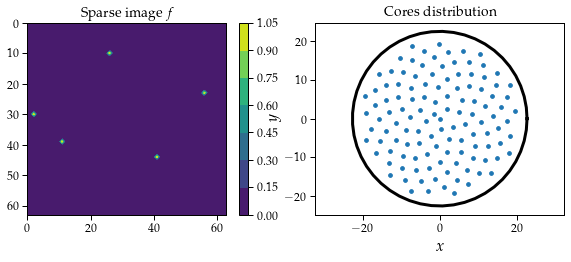

In [4]:
N = 64 # image sidelength
K = 5 # sparsity
Q = 120 # Number of cores
M = 180 # Number of measurements

"Define the sparse object"
usaf = imageio.imread(os.path.join(updir(os.getcwd(),2), "images/usaf.jpg"))[:,:,0] / 255.
usaf = 1*(usaf>254) # make the image binary

pos_x = np.random.randint(0, high=N, size=K)
pos_y = np.random.randint(0, high=N, size=K)
f = np.zeros((N,N))
for i in range(K):
    f[pos_x[i], pos_y[i]] = (-1)**i

f_flat = f.reshape(-1)

"Fermat spiral"
diam_endo = np.sqrt(2)*(N/2) # Must be N for coherency between image resolution and cores distances
# diam_endo = N//2
pos_sources = LE_cores (diam_endo, Q, sources_shape = 'fermat')
pos_inds = np.round((pos_sources+diam_endo/2)*N/diam_endo).astype(int) # convert sources positions to indices in R^(NxN) space.

"Define Om = {p_j - p_k, j,k \in [Q]}"
Om_x = np.subtract.outer(pos_inds[0,:], pos_inds[0,:]).astype(int)
Om_y = np.subtract.outer(pos_inds[1,:], pos_inds[1,:]).astype(int)

"Compute the multiplicity of each frequency"
multiplicities = ind_multiplicity(Om_x, Om_y)
"Compute the interferometric matrix" 
IntM = S_Om(T(f), Om_x, Om_y, mult_mat=multiplicities)

a_ij = (np.random.randn(M,Q)+1j*np.random.randn(M,Q))/np.sqrt(2)

"Plots"
fig = plt.figure(figsize=(8,4))
axs = subplot_axs(fig, 1,2)
im0 = axs[0].contourf(np.abs(f), cmap='viridis')
axs[0].invert_yaxis()
axs[0].set_title('Sparse image $f$')
fig.colorbar(im0, ax=axs[0])
theta = np.linspace(0,2*np.pi,50)
axs[1].plot(diam_endo/2*np.cos(theta), diam_endo/2*np.sin(theta), 'k', label='Borders')
axs[1].axis('equal')
cores = axs[1].scatter(pos_sources[0], pos_sources[1], marker='o', label='Sources', s = 15)
labels(axs[1], r'Cores distribution', '$x$', '$y$')
plt.show()

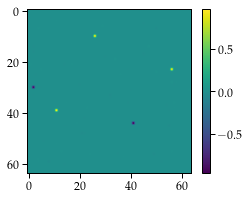

SNR: 21.41 dB


In [5]:
SNR_target = 70
opt_tol =  np.linalg.norm(f)*10**(-SNR_target/20)
bpalg = lambda A, b: spgl1.spg_bp(A, b, opt_tol=opt_tol)

A_ROP2 = ROP_model2(Om_x, Om_y, a_ij, N)
y_ROP = A_ROP2@f_flat
recovery = bpalg(A_ROP2, y_ROP)
x_ROP = recovery[0].reshape((N,N))

plt.figure(figsize=(4,3))
plt.imshow(x_ROP, cmap='viridis')
plt.colorbar()
plt.show()

print('SNR: {:.2f} dB'.format(snr(f, x_ROP)) )

(K,M, trial) = (2,300,0)
57.878585933548365
(K,M, trial) = (4,300,0)
54.52425399337617
(K,M, trial) = (6,300,0)
26.04200405908721
(K,M, trial) = (8,300,0)
50.18900231306334
(K,M, trial) = (10,300,0)
53.03315059185511
(K,M, trial) = (12,300,0)
49.36654686063989
(K,M, trial) = (14,300,0)
20.501031192814757
(K,M, trial) = (16,300,0)
16.372926816717523
(K,M, trial) = (18,300,0)
12.94157217530558
(K,M, trial) = (20,300,0)
11.340106532860865


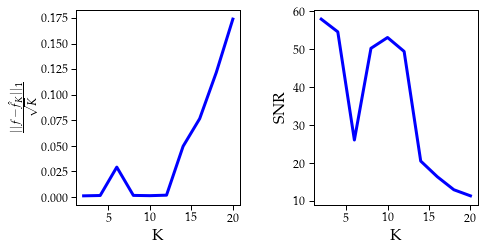

In [6]:
Ks = np.arange(2, 22, 2).astype(int)
# Ms = np.round(30+Ks*np.log(np.exp(1)*N**2/Ks)).astype(int)
M = 300
n_trials = 1

SNR_target = 50

errors = np.zeros((n_trials, len(Ks)))
SNRs = np.zeros( (n_trials, len(Ks)))

for j, K in enumerate(Ks):
    for n in range(n_trials):
        # M = Ms[j]
        print('(K,M, trial) = ({},{},{})'.format(K,M,n))

        pos_x = np.random.randint(0, high=N, size=K)
        pos_y = np.random.randint(0, high=N, size=K)
        f = np.zeros((N,N))
        for i in range(K):
            f[pos_x[i], pos_y[i]] = (-1)**i
        f_flat = f.reshape(-1)

        a_ij = (np.random.randn(M,Q)+1j*np.random.randn(M,Q))/np.sqrt(2)

        opt_tol =  np.linalg.norm(f)*10**(-SNR_target/20)
        bpalg = lambda A, b: spgl1.spg_bp(A, b, opt_tol=opt_tol)

        A_ROP2 = ROP_model2(Om_x, Om_y, a_ij, N)
        y_ROP = A_ROP2@f_flat
        recovery = bpalg(A_ROP2, y_ROP)
        x_ROP = recovery[0].reshape((N,N))

        errors[n,j] = np.linalg.norm(f-x_ROP, 1)/np.sqrt(K)
        SNRs[n,j] = snr(f, x_ROP)
        print("SNR: {:.2f}dB".format(SNRs[n,j]))

"Plot"
fig = plt.figure(figsize=(6,3))
ax1 = fig.add_axes([0.05, 0.05, 0.38, 0.9])
ax2 = fig.add_axes([0.6, 0.05, 0.38, 0.9])
ax1.plot(Ks, np.mean(errors,axis=0), 'b')
ax1.set_xlabel('K')
ax1.set_ylabel(r'$\frac{ ||f-\hat{f}_K||_1}{\sqrt{K}}$')
ax2.plot(Ks, np.mean(SNRs, axis=0), 'b')
ax2.set_xlabel('K')
ax2.set_ylabel('SNR')
plt.show()